In [10]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("Distributions")

using LinearAlgebra, Plots
import MeshCat as mc 
using Test, Distributions
using Random
import ForwardDiff as FD 
using Interpolations   
import ECOS  
using ProgressMeter

  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`

   Resolving package versions...


  No Changes to `C:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`
  No Changes to `C:\Users\scott\Documents\OCRL\MPCwZAC\Manifest.toml`

In [11]:
#include(joinpath(@__DIR__,"ref_traj.jl"))
#include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))
#include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v2.jl"))
#include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v3.jl"))

include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v4_wind.jl"))
include(joinpath(@__DIR__,"convex_mpc.jl"))
include(joinpath(@__DIR__,"kalman_filter.jl"))


kalman_filter (generic function with 1 method)

In [12]:
########## FUNCTIONS ###########

# converting from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end

# Controls equilibrium point
function controls_equilibrium(u0::Vector, X̄, wind_velocity, model, ode; tol= 1e-6, max_iters= 100, verbose= false)::Vector{Vector{Float64}}

    "
        Determining the equilibrium point for controls at hover
            - use Newton's method (minimize over u for least squares cost)
            - initial guess= hover location for planar hexarotor ([(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)])
    " 

    # initialize U
    U = [zeros(eltype(u0), length(u0)) for i= 1:max_iters] #empty vector for Newton guesses
    U[1]= u0 #initialize with first guess (which is simply counteracting gravity (mg/n_inputs)

    #wind_velocity= [0.0;0.0;0.0]

    for i = (1:max_iters-1)
        
        residual= (1/2) * (ode(model, X̄, U[i], wind_velocity))'* ode(model, X̄, U[i], wind_velocity) # least squares cost function
        δfδu= FD.jacobian(du -> ode(model, X̄, du, wind_velocity), U[i]) # jacobian of f with respect to u

        ∇residual= (δfδu)' * ode(model, X̄, U[i], wind_velocity) # gradient of cost function- to solve for u, this should be zero
        ∇²residual= ((δfδu)' * δfδu) + 1e-4*(I(6)) # hessian (gauss newton version) of cost function 
        # regularization term to ensure full rank
        #println("rank hessian: ", rank(∇²residual))

        norm_residual= norm(residual)

        if verbose 
            print("iter: $i    |residual|: $norm_residual   \n")
        end

        # check against tol
        # if converged, return U[1:i]
        if norm_residual < tol
            return U[1:i]
        end

        Δu= ∇²residual\(-∇residual) # Newton step
        #println(Δu)

        # update U
        U[i+1]= U[i] + vec(Δu)
        #println(U[i+1])
    end
    error("Newton's method did not converge")
end
 
function sample_wind(mean, std_dev)
    # normal distribution with the specified mean and standard deviation
    # std_dev= zeros(3)
    # for i= 1:length(mean)
    #     std_dev[i]= [(mean[i]- (1/4)*mean[i])/0.34]
    # end

    # mean= Vector{Real}(mean) 
    # std_dev=Vector{Real}(std_dev) 
    
    normal_dist_x = Normal(mean[1], std_dev[1])
    normal_dist_y = Normal(mean[2], std_dev[2])
    normal_dist_z = Normal(mean[3], std_dev[3])

    # generate a random number from the specified distribution
    wind = [rand(normal_dist_x); rand(normal_dist_y); rand(normal_dist_z)]
    return wind
end

sample_wind (generic function with 1 method)

In [26]:
Random.seed!(1)
#### MODEL PARAMETERS ####
Ixx= 2.331e2
Ixy= -0.7923
Ixz= 2.859
Iyx= -.7923
Iyy= 2.322e2
Iyz= 2.187
Izx= 2.859
Izy= 2.187
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx -Ixy -Ixz; -Iyx Iyy -Iyz; -Izx -Izy Izz]), #inertia matrix- determined from CAD
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 13.0,#13, # constant thrust coefficient- this was guessed based on the quadrotor dynamics (linear relationship based on mass...)
    km= 0.0245,#0.0245, # propeller drag coefficient (0.0245 for quadrotor (0.5kg)
    dt= 0.02, # frequency
    α= 0.49, # radians
    β= 0.33 # radians
)
##########

#### PROBLEM DETAILS ####
# problem size 
nx = 12 # number of states
nu = 6 # number of controls
nx_a = 15 # number of states when augemented with wind
dt = model.dt
tf = 10
t_vec = 0:dt:tf
N = length(t_vec)
N_mpc= 80 # MPC horizon
N_sim= N+ N_mpc 
t_vec_sim = 0:dt:((N_sim-1)*dt)
m= model.mass
kf= model.kf

println("N= ", N)
##########

##### generate wind #####
#wind_velocity= sample_wind(model.wind_mean, model.wind_stdev)
wind_velocity = [0.4, 0.0, 0.0]
wind_stdev= [0.05; 0.05; 0.05]
# Initialize wind parameters
wind_dynamics = zeros(nx, 3)
wind_dynamics[4, 1] = 1  # Wind effect on vx
wind_dynamics[5, 2] = 1  # Wind effect on vy
wind_dynamics[6, 3] = 1  # Wind effect on vz
#########

#### EQUILIBRIUM POINT FOR HOVER ####
# newton method stuff to find the controls equilibrium point
# hover state
X̄= [0.0; 0.0; 3.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0] #+ 0.0001*randn(nx) # add a little bit of noise to reduce numerical instabilities
# initial guess for control equilibrium point- I made this the hover thrust for the planar hexrotor
u0= [(9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu))] 
#u0= [0.0; 10.0; 0.0; 0.0; 0.0; 0.0] 

# I determined these experimentally
u_min= -30 * ones(nu) #-100, -250
u_max= 30 * ones(nu) #100, 250
U= controls_equilibrium(u0, X̄, [0,0,0], model, hexrotor_dynamics, tol= 1e-6, max_iters= 100, verbose= true)
Ū= U[end] # control equilibrium point! will linearize around this point
println("U equilibrium point= ", Ū)
##########

#### LINEARIZATION ####
# calculate A and B matrices (jacobians of discrete dynamics with respect to X̄ and Ū)
A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ū, [0,0,0], dt), X̄)
B= FD.jacobian(du -> rk4(model, hexrotor_dynamics, X̄, du, [0,0,0], dt), Ū)

#### Define costs ####
Q = diagm([100,100,100,
10,10,10,
100,100,100,
10,10,10])

Qf = 10*Q

R = 1.0*diagm(ones(nu))

# IHLQR- using the steady state P as Qn for the MPC controller
Kinf= B'
max_iters= 1e6
P= deepcopy(Qf) #initialize p
for i= 1:max_iters
    Kinf = (R .+ B' * P * B)\  (B' * P * A)
    P_recursion = Q + A' * P * A - A' * P * B * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end 
    # update P for next iteration
    P = 1*P_recursion
end
# ensure that Qn is hermitian 
Qf= 1*(P +P')/2;
##########

#### KALMAN FILTER PARAMETERS ####
# process noise covariance
σ_w= 0.9 #0.08
#W= σ_w^2 * I(15)
W= (wind_stdev[1]^2) *I(15)

# measurement noise covariance 
σ_v= 0.9 #0.08
V= σ_v^2 * I(12)

# Kalman covariance
Σ= [zeros(15, 15) for i= 1:N_sim]
Σ[1]= zeros(15, 15)
##########


#### TESTS/CHECKS ####
# double check convergence of the cost function when the equilibrium is used  
@test norm((1/2) * (hexrotor_dynamics(model, X̄, U[end], [0,0,0]))'* hexrotor_dynamics(model, X̄, U[end], wind_velocity)) < 1e-3

# check the norm of the nonlinear disretized dynamics to make sure they match at the equilibrium point
println("norm between X̄ and discretized dynamics= ", norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, [0,0,0], dt)))
@assert norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, [0,0,0], dt)) < 1e-3

# check for system stability
eig= abs.(eigvals(A- B*Kinf))
# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end
println("eigenvalues= ",eig)

# check controllability

# check observability

##########


N= 501
iter: 1    |residual|: 4943.863490868141   
iter: 2    |residual|: 5.38473043854718e-6   
iter: 3    |residual|: 3.758045956944573e-8   
U equilibrium point= [1.5221764064288532, 0.003760421701990653, 1.5186725809815702, 1.5215686179694983, -0.003148158040507644, 1.5192802940479662]


norm between X̄ and discretized dynamics= 5.48314126232295e-6
The system is stable.
eigenvalues= [0.7805808646375748, 0.9192453423055129, 0.9192453423055129, 0.9276674228797178, 0.9276674228797178, 0.936668787226352, 0.9923057021590072, 0.9923057021590072, 0.9959403060998886, 0.9959403060998886, 0.9976214242783037, 0.9976214242783037]


In [27]:
Random.seed!(1) 

x0= 1*X̄ # initialize the simulation with X̄

#### SIMULATION SETUP ####
# create "trajectory" of hover for the length of the simulation
X_ref= [X̄ for i= 1:N_sim]
U_ref= [Ū for i= 1:N_sim]

du_min = u_min .- Ū
du_max = u_max .- Ū

# simulation states
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = 1* x0 # + randn(n_states) * 0.001

#Utarget= -B\((A- I(nx)) *X̄ + D*wind_velocity)

# # ##########################
ΔX_ref = [(X_ref[i] - X̄) for i = 1:length(X_ref)]
ΔU_ref = [(U_ref[i] - Ū) for i = 1:length(U_ref)]
# pad the end with end conditions
ΔX_ref = [ΔX_ref...,[ΔX_ref[N] for i = 1:N]...]  # Xref for MPC, padded with xgoals
ΔU_ref = [ΔU_ref..., [ΔU_ref[N-1] for i=1:N-1]...] # Uref for MPC, padded with end controls


# simulation states
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = 1*x0 # + randn(n_states) * 0.001
ΔX_sim = [zeros(nx) for i = 1:N_sim]
ΔX_sim[1] = x0 - X̄ 

# simulation controls (from MPC)
U_sim = [zeros(nu) for i = 1:N_sim-1]
ΔU_sim = [zeros(nu) for i = 1:N_sim-1]

# estimated states (from Kalman)
x̂ = [zeros(nx) for i = 1:N_sim]
x̂[1] = X_sim[1]
Δx̂ = [zeros(nx) for i = 1:N_sim]
Δx̂[1] = x0- X̄

dxg= 1* ΔX_ref[N]


##############################
estimated_wind= [zeros(nx) for i = 1:N_sim]
estimated_wind[1]= wind_velocity

#### u target stuff
#Utarget= -B\((A- I(nx)) *X̄ + wind_dynamics*wind_velocity)

# simulate 
@showprogress "simulating" for i = 1:N_sim-1     
    #update wind
    #wind_velocity = wind_velocity + randn(3).*wind_stdev

    # given a window of N_mpc timesteps, get current reference trajectory
    ΔX_ref_horizon = ΔX_ref[i: (i+ N_mpc-1)] 

    # ΔU_ref_horizon= ΔU_ref[i: (i+ N_mpc-1)]
    # TODO implement live Utarget updating
    Utarget= -B\((A - I(nx)) * X̄ + wind_dynamics * estimated_wind[i])
    ΔU_ref_horizon= [Utarget for i= 1:N_mpc]

    # call convex mpc controller with state estimate 
    ΔU_sim[i] = convex_mpc(A, B, wind_dynamics, ΔX_ref_horizon, ΔU_ref_horizon, Δx̂[i], dxg, du_min, du_max, N_mpc, Q, R, Qf, estimated_wind[i]) #+ randn(n_inputs) * 0.01
    U_sim[i] = ΔU_sim[i] + Ū

    ### i think if we want to simulate with the nonlinear dynamcis, we don't need the Deltas... i think we need that if we sim with the linearized dynamcis
    X_sim[i+1] = rk4(model, hexrotor_dynamics, X_sim[i], U_sim[i], wind_velocity, dt)+ wind_dynamics * wind_velocity #+ randn(n_states)*0.001
    ΔX_sim[i+1]= X_sim[i+1] - X̄
 
    C= I(12)
    v_k_state= 0.01 * randn(12)
    measurement= C * ΔX_sim[i+1] + v_k_state # measurement is taken from the actual simulated dynamics 

    Δx̂[i+1], estimated_wind[i+1], Σ[i+1] = kalman_filter(Δx̂[i], measurement, wind_velocity, ΔU_sim[i], Σ[i], A, B, wind_dynamics, W, V) 
    x̂[i+1]= Δx̂[i+1] + X̄
end



simulating   0%|█                                        |  ETA: 0:02:36

simulating   1%|█                                        |  ETA: 0:02:26

simulating   1%|█                                        |  ETA: 0:02:23

simulating   1%|█                                        |  ETA: 0:02:26

simulating   1%|█                                        |  ETA: 0:02:22

simulating   1%|█                                        |  ETA: 0:02:20

simulating   1%|█                                        |  ETA: 0:02:20

simulating   2%|█                                        |  ETA: 0:02:18

simulating   2%|█                                        |  ETA: 0:02:17

simulating   2%|█                                        |  ETA: 0:02:17

simulating   2%|█                                        |  ETA: 0:02:16

simulating   2%|█                                        |  ETA: 0:02:15

simulating   2%|█                                        |  ETA: 0:02:15

simulating   3%|██                                       |  ETA: 0:02:14

simulating   3%|██                                       |  ETA: 0:02:14

simulating   3%|██                                       |  ETA: 0:02:14

simulating   3%|██                                       |  ETA: 0:02:13

simulating   3%|██                                       |  ETA: 0:02:13

simulating   3%|██                                       |  ETA: 0:02:12

simulating   4%|██                                       |  ETA: 0:02:12

simulating   4%|██                                       |  ETA: 0:02:13

simulating   4%|██                                       |  ETA: 0:02:12

simulating   4%|██                                       |  ETA: 0:02:11

simulating   4%|██                                       |  ETA: 0:02:12

simulating   4%|██                                       |  ETA: 0:02:12

simulating   5%|██                                       |  ETA: 0:02:11

simulating   5%|██                                       |  ETA: 0:02:11

simulating   5%|███                                      |  ETA: 0:02:11

simulating   5%|███                                      |  ETA: 0:02:11

simulating   5%|███                                      |  ETA: 0:02:11

simulating   6%|███                                      |  ETA: 0:02:11

simulating   6%|███                                      |  ETA: 0:02:10

simulating   6%|███                                      |  ETA: 0:02:10

simulating   6%|███                                      |  ETA: 0:02:10

simulating   6%|███                                      |  ETA: 0:02:09

simulating   6%|███                                      |  ETA: 0:02:09

simulating   7%|███                                      |  ETA: 0:02:09

simulating   7%|███                                      |  ETA: 0:02:09

simulating   7%|███                                      |  ETA: 0:02:09

simulating   7%|███                                      |  ETA: 0:02:09

simulating   7%|███                                      |  ETA: 0:02:09

simulating   7%|████                                     |  ETA: 0:02:09

simulating   8%|████                                     |  ETA: 0:02:09

simulating   8%|████                                     |  ETA: 0:02:08

simulating   8%|████                                     |  ETA: 0:02:08

simulating   8%|████                                     |  ETA: 0:02:08

simulating   8%|████                                     |  ETA: 0:02:08

simulating   8%|████                                     |  ETA: 0:02:07

simulating   9%|████                                     |  ETA: 0:02:07

simulating   9%|████                                     |  ETA: 0:02:07

simulating   9%|████                                     |  ETA: 0:02:06

simulating   9%|████                                     |  ETA: 0:02:06

simulating   9%|████                                     |  ETA: 0:02:06

simulating   9%|████                                     |  ETA: 0:02:06

simulating  10%|████                                     |  ETA: 0:02:05

simulating  10%|█████                                    |  ETA: 0:02:05

simulating  10%|█████                                    |  ETA: 0:02:05

simulating  10%|█████                                    |  ETA: 0:02:05

simulating  10%|█████                                    |  ETA: 0:02:05

simulating  11%|█████                                    |  ETA: 0:02:05

simulating  11%|█████                                    |  ETA: 0:02:04

simulating  11%|█████                                    |  ETA: 0:02:04

simulating  11%|█████                                    |  ETA: 0:02:04

simulating  11%|█████                                    |  ETA: 0:02:04

simulating  11%|█████                                    |  ETA: 0:02:04

simulating  12%|█████                                    |  ETA: 0:02:04

simulating  12%|█████                                    |  ETA: 0:02:03

simulating  12%|█████                                    |  ETA: 0:02:03

simulating  12%|█████                                    |  ETA: 0:02:03

simulating  12%|██████                                   |  ETA: 0:02:03

simulating  12%|██████                                   |  ETA: 0:02:02

simulating  13%|██████                                   |  ETA: 0:02:02

simulating  13%|██████                                   |  ETA: 0:02:02

simulating  13%|██████                                   |  ETA: 0:02:01

simulating  13%|██████                                   |  ETA: 0:02:01

simulating  13%|██████                                   |  ETA: 0:02:01

simulating  13%|██████                                   |  ETA: 0:02:01

simulating  14%|██████                                   |  ETA: 0:02:01

simulating  14%|██████                                   |  ETA: 0:02:01

simulating  14%|██████                                   |  ETA: 0:02:00

simulating  14%|██████                                   |  ETA: 0:02:00

simulating  14%|██████                                   |  ETA: 0:02:00

simulating  14%|██████                                   |  ETA: 0:02:00

simulating  15%|███████                                  |  ETA: 0:02:00

simulating  15%|███████                                  |  ETA: 0:02:00

simulating  15%|███████                                  |  ETA: 0:01:59

simulating  15%|███████                                  |  ETA: 0:01:59

simulating  15%|███████                                  |  ETA: 0:01:59

simulating  16%|███████                                  |  ETA: 0:01:58

simulating  16%|███████                                  |  ETA: 0:01:58

simulating  16%|███████                                  |  ETA: 0:01:58

simulating  16%|███████                                  |  ETA: 0:01:58

simulating  16%|███████                                  |  ETA: 0:01:58

simulating  16%|███████                                  |  ETA: 0:01:57

simulating  17%|███████                                  |  ETA: 0:01:57

simulating  17%|███████                                  |  ETA: 0:01:57

simulating  17%|███████                                  |  ETA: 0:01:57

simulating  17%|███████                                  |  ETA: 0:01:56

simulating  17%|████████                                 |  ETA: 0:01:56

simulating  17%|████████                                 |  ETA: 0:01:56

simulating  18%|████████                                 |  ETA: 0:01:56

simulating  18%|████████                                 |  ETA: 0:01:56

simulating  18%|████████                                 |  ETA: 0:01:55

simulating  18%|████████                                 |  ETA: 0:01:55

simulating  18%|████████                                 |  ETA: 0:01:55

simulating  18%|████████                                 |  ETA: 0:01:55

simulating  19%|████████                                 |  ETA: 0:01:55

simulating  19%|████████                                 |  ETA: 0:01:55

simulating  19%|████████                                 |  ETA: 0:01:55

simulating  19%|████████                                 |  ETA: 0:01:55

simulating  19%|████████                                 |  ETA: 0:01:54

simulating  19%|████████                                 |  ETA: 0:01:54

simulating  20%|█████████                                |  ETA: 0:01:54

simulating  20%|█████████                                |  ETA: 0:01:54

simulating  20%|█████████                                |  ETA: 0:01:54

simulating  20%|█████████                                |  ETA: 0:01:53

simulating  20%|█████████                                |  ETA: 0:01:53

simulating  21%|█████████                                |  ETA: 0:01:53

simulating  21%|█████████                                |  ETA: 0:01:53

simulating  21%|█████████                                |  ETA: 0:01:52

simulating  21%|█████████                                |  ETA: 0:01:52

simulating  21%|█████████                                |  ETA: 0:01:52

simulating  21%|█████████                                |  ETA: 0:01:51

simulating  22%|█████████                                |  ETA: 0:01:51

simulating  22%|█████████                                |  ETA: 0:01:51

simulating  22%|█████████                                |  ETA: 0:01:51

simulating  22%|██████████                               |  ETA: 0:01:50

simulating  22%|██████████                               |  ETA: 0:01:50

simulating  22%|██████████                               |  ETA: 0:01:50

simulating  23%|██████████                               |  ETA: 0:01:50

simulating  23%|██████████                               |  ETA: 0:01:49

simulating  23%|██████████                               |  ETA: 0:01:49

simulating  23%|██████████                               |  ETA: 0:01:49

simulating  23%|██████████                               |  ETA: 0:01:49

simulating  23%|██████████                               |  ETA: 0:01:48

simulating  24%|██████████                               |  ETA: 0:01:48

simulating  24%|██████████                               |  ETA: 0:01:48

simulating  24%|██████████                               |  ETA: 0:01:48

simulating  24%|██████████                               |  ETA: 0:01:48

simulating  24%|██████████                               |  ETA: 0:01:47

simulating  24%|███████████                              |  ETA: 0:01:47

simulating  25%|███████████                              |  ETA: 0:01:47

simulating  25%|███████████                              |  ETA: 0:01:47

simulating  25%|███████████                              |  ETA: 0:01:46

simulating  25%|███████████                              |  ETA: 0:01:46

simulating  25%|███████████                              |  ETA: 0:01:46

simulating  26%|███████████                              |  ETA: 0:01:46

simulating  26%|███████████                              |  ETA: 0:01:45

simulating  26%|███████████                              |  ETA: 0:01:45

simulating  26%|███████████                              |  ETA: 0:01:45

simulating  26%|███████████                              |  ETA: 0:01:44

simulating  26%|███████████                              |  ETA: 0:01:44

simulating  27%|███████████                              |  ETA: 0:01:44

simulating  27%|███████████                              |  ETA: 0:01:44

simulating  27%|████████████                             |  ETA: 0:01:44

simulating  27%|████████████                             |  ETA: 0:01:43

simulating  27%|████████████                             |  ETA: 0:01:43

simulating  27%|████████████                             |  ETA: 0:01:43

simulating  28%|████████████                             |  ETA: 0:01:43

simulating  28%|████████████                             |  ETA: 0:01:42

simulating  28%|████████████                             |  ETA: 0:01:42

simulating  28%|████████████                             |  ETA: 0:01:42

simulating  28%|████████████                             |  ETA: 0:01:41

simulating  28%|████████████                             |  ETA: 0:01:41

simulating  29%|████████████                             |  ETA: 0:01:41

simulating  29%|████████████                             |  ETA: 0:01:41

simulating  29%|████████████                             |  ETA: 0:01:41

simulating  29%|████████████                             |  ETA: 0:01:40

simulating  29%|█████████████                            |  ETA: 0:01:40

simulating  29%|█████████████                            |  ETA: 0:01:40

simulating  30%|█████████████                            |  ETA: 0:01:40

simulating  30%|█████████████                            |  ETA: 0:01:39

simulating  30%|█████████████                            |  ETA: 0:01:39

simulating  30%|█████████████                            |  ETA: 0:01:39

simulating  30%|█████████████                            |  ETA: 0:01:39

simulating  31%|█████████████                            |  ETA: 0:01:38

simulating  31%|█████████████                            |  ETA: 0:01:38

simulating  31%|█████████████                            |  ETA: 0:01:38

simulating  31%|█████████████                            |  ETA: 0:01:38

simulating  31%|█████████████                            |  ETA: 0:01:37

simulating  31%|█████████████                            |  ETA: 0:01:37

simulating  32%|█████████████                            |  ETA: 0:01:37

simulating  32%|██████████████                           |  ETA: 0:01:37

simulating  32%|██████████████                           |  ETA: 0:01:37

simulating  32%|██████████████                           |  ETA: 0:01:36

simulating  32%|██████████████                           |  ETA: 0:01:36

simulating  32%|██████████████                           |  ETA: 0:01:36

simulating  33%|██████████████                           |  ETA: 0:01:36

simulating  33%|██████████████                           |  ETA: 0:01:36

simulating  33%|██████████████                           |  ETA: 0:01:35

simulating  33%|██████████████                           |  ETA: 0:01:35

simulating  33%|██████████████                           |  ETA: 0:01:35

simulating  33%|██████████████                           |  ETA: 0:01:35

simulating  34%|██████████████                           |  ETA: 0:01:34

simulating  34%|██████████████                           |  ETA: 0:01:34

simulating  34%|██████████████                           |  ETA: 0:01:34

simulating  34%|██████████████                           |  ETA: 0:01:34

simulating  34%|███████████████                          |  ETA: 0:01:34

simulating  34%|███████████████                          |  ETA: 0:01:33

simulating  35%|███████████████                          |  ETA: 0:01:33

simulating  35%|███████████████                          |  ETA: 0:01:33

simulating  35%|███████████████                          |  ETA: 0:01:33

simulating  35%|███████████████                          |  ETA: 0:01:32

simulating  35%|███████████████                          |  ETA: 0:01:32

simulating  36%|███████████████                          |  ETA: 0:01:32

simulating  36%|███████████████                          |  ETA: 0:01:32

simulating  36%|███████████████                          |  ETA: 0:01:31

simulating  36%|███████████████                          |  ETA: 0:01:31

simulating  36%|███████████████                          |  ETA: 0:01:31

simulating  36%|███████████████                          |  ETA: 0:01:31

simulating  37%|███████████████                          |  ETA: 0:01:30

simulating  37%|████████████████                         |  ETA: 0:01:30

simulating  37%|████████████████                         |  ETA: 0:01:30

simulating  37%|████████████████                         |  ETA: 0:01:30

simulating  37%|████████████████                         |  ETA: 0:01:29

simulating  37%|████████████████                         |  ETA: 0:01:29

simulating  38%|████████████████                         |  ETA: 0:01:29

simulating  38%|████████████████                         |  ETA: 0:01:29

simulating  38%|████████████████                         |  ETA: 0:01:28

simulating  38%|████████████████                         |  ETA: 0:01:28

simulating  38%|████████████████                         |  ETA: 0:01:28

simulating  38%|████████████████                         |  ETA: 0:01:28

simulating  39%|████████████████                         |  ETA: 0:01:27

simulating  39%|████████████████                         |  ETA: 0:01:27

simulating  39%|████████████████                         |  ETA: 0:01:27

simulating  39%|█████████████████                        |  ETA: 0:01:27

simulating  39%|█████████████████                        |  ETA: 0:01:26

simulating  39%|█████████████████                        |  ETA: 0:01:26

simulating  40%|█████████████████                        |  ETA: 0:01:26

simulating  40%|█████████████████                        |  ETA: 0:01:26

simulating  40%|█████████████████                        |  ETA: 0:01:25

simulating  40%|█████████████████                        |  ETA: 0:01:25

simulating  40%|█████████████████                        |  ETA: 0:01:25

simulating  41%|█████████████████                        |  ETA: 0:01:25

simulating  41%|█████████████████                        |  ETA: 0:01:24

simulating  41%|█████████████████                        |  ETA: 0:01:24

simulating  41%|█████████████████                        |  ETA: 0:01:24

simulating  41%|█████████████████                        |  ETA: 0:01:24

simulating  41%|█████████████████                        |  ETA: 0:01:23

simulating  42%|██████████████████                       |  ETA: 0:01:23

simulating  42%|██████████████████                       |  ETA: 0:01:23

simulating  42%|██████████████████                       |  ETA: 0:01:23

simulating  42%|██████████████████                       |  ETA: 0:01:22

simulating  42%|██████████████████                       |  ETA: 0:01:22

simulating  42%|██████████████████                       |  ETA: 0:01:22

simulating  43%|██████████████████                       |  ETA: 0:01:22

simulating  43%|██████████████████                       |  ETA: 0:01:21

simulating  43%|██████████████████                       |  ETA: 0:01:21

simulating  43%|██████████████████                       |  ETA: 0:01:21

simulating  43%|██████████████████                       |  ETA: 0:01:21

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  43%|██████████████████                       |  ETA: 0:01:21

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  44%|██████████████████                       |  ETA: 0:01:20

simulating  44%|██████████████████                       |  ETA: 0:01:20

simulating  44%|███████████████████                      |  ETA: 0:01:20

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  44%|███████████████████                      |  ETA: 0:01:20

simulating  44%|███████████████████                      |  ETA: 0:01:20

simulating  44%|███████████████████                      |  ETA: 0:01:19

simulating  45%|███████████████████                      |  ETA: 0:01:19

simulating  45%|███████████████████                      |  ETA: 0:01:19

simulating  45%|███████████████████                      |  ETA: 0:01:19

simulating  45%|███████████████████                      |  ETA: 0:01:19

simulating  45%|███████████████████                      |  ETA: 0:01:18

simulating  46%|███████████████████                      |  ETA: 0:01:18

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  46%|███████████████████                      |  ETA: 0:01:18

simulating  46%|███████████████████                      |  ETA: 0:01:18

simulating  46%|███████████████████                      |  ETA: 0:01:18

simulating  46%|███████████████████                      |  ETA: 0:01:17

simulating  46%|████████████████████                     |  ETA: 0:01:17

simulating  47%|████████████████████                     |  ETA: 0:01:17

simulating  47%|████████████████████                     |  ETA: 0:01:17

simulating  47%|████████████████████                     |  ETA: 0:01:16

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  47%|████████████████████                     |  ETA: 0:01:16

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  47%|████████████████████                     |  ETA: 0:01:16

simulating  47%|████████████████████                     |  ETA: 0:01:16

simulating  48%|████████████████████                     |  ETA: 0:01:15

simulating  48%|████████████████████                     |  ETA: 0:01:15

simulating  48%|████████████████████                     |  ETA: 0:01:15

simulating  48%|████████████████████                     |  ETA: 0:01:15

simulating  48%|████████████████████                     |  ETA: 0:01:15

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  48%|████████████████████                     |  ETA: 0:01:14

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  49%|████████████████████                     |  ETA: 0:01:14

simulating  49%|█████████████████████                    |  ETA: 0:01:14

simulating  49%|█████████████████████                    |  ETA: 0:01:14

simulating  49%|█████████████████████                    |  ETA: 0:01:13

simulating  49%|█████████████████████                    |  ETA: 0:01:13

simulating  49%|█████████████████████                    |  ETA: 0:01:13

simulating  50%|█████████████████████                    |  ETA: 0:01:13

simulating  50%|█████████████████████                    |  ETA: 0:01:13

simulating  50%|█████████████████████                    |  ETA: 0:01:12

simulating  50%|█████████████████████                    |  ETA: 0:01:12

simulating  50%|█████████████████████                    |  ETA: 0:01:12

simulating  51%|█████████████████████                    |  ETA: 0:01:12

simulating  51%|█████████████████████                    |  ETA: 0:01:11

simulating  51%|█████████████████████                    |  ETA: 0:01:11

simulating  51%|█████████████████████                    |  ETA: 0:01:11

simulating  51%|█████████████████████                    |  ETA: 0:01:11

simulating  51%|██████████████████████                   |  ETA: 0:01:11

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  52%|██████████████████████                   |  ETA: 0:01:10

simulating  52%|██████████████████████                   |  ETA: 0:01:10

simulating  52%|██████████████████████                   |  ETA: 0:01:10

simulating  52%|██████████████████████                   |  ETA: 0:01:10

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  52%|██████████████████████                   |  ETA: 0:01:09

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  52%|██████████████████████                   |  ETA: 0:01:09

simulating  53%|██████████████████████                   |  ETA: 0:01:09

simulating  53%|██████████████████████                   |  ETA: 0:01:09

simulating  53%|██████████████████████                   |  ETA: 0:01:08

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  53%|██████████████████████                   |  ETA: 0:01:08

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  53%|██████████████████████                   |  ETA: 0:01:08

simulating  53%|██████████████████████                   |  ETA: 0:01:08

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  54%|██████████████████████                   |  ETA: 0:01:07

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  54%|███████████████████████                  |  ETA: 0:01:07

simulating  54%|███████████████████████                  |  ETA: 0:01:07

simulating  54%|███████████████████████                  |  ETA: 0:01:07

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  54%|███████████████████████                  |  ETA: 0:01:07

simulating  54%|███████████████████████                  |  ETA: 0:01:06

simulating  55%|███████████████████████                  |  ETA: 0:01:06

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  55%|███████████████████████                  |  ETA: 0:01:06

simulating  55%|███████████████████████                  |  ETA: 0:01:06

simulating  55%|███████████████████████                  |  ETA: 0:01:05

simulating  55%|███████████████████████                  |  ETA: 0:01:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|███████████████████████                  |  ETA: 0:01:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|███████████████████████                  |  ETA: 0:01:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|███████████████████████                  |  ETA: 0:01:04

simulating  56%|███████████████████████                  |  ETA: 0:01:04

simulating  56%|████████████████████████                 |  ETA: 0:01:04

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|████████████████████████                 |  ETA: 0:01:04

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:01:04

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:01:03

simulating  57%|████████████████████████                 |  ETA: 0:01:03

simulating  57%|████████████████████████                 |  ETA: 0:01:03

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:01:03

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:01:02

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:01:02

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:01:02

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:01:02

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:01:01

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:01:01

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:01:01

simulating  59%|█████████████████████████                |  ETA: 0:01:01

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|█████████████████████████                |  ETA: 0:01:00

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|█████████████████████████                |  ETA: 0:01:00

simulating  59%|█████████████████████████                |  ETA: 0:01:00

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|█████████████████████████                |  ETA: 0:01:00

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|█████████████████████████                |  ETA: 0:00:59

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:59

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:59

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:59

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:59

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:58

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|█████████████████████████                |  ETA: 0:00:58

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|█████████████████████████                |  ETA: 0:00:58

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|█████████████████████████                |  ETA: 0:00:58

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|██████████████████████████               |  ETA: 0:00:57

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|██████████████████████████               |  ETA: 0:00:57

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|██████████████████████████               |  ETA: 0:00:57

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:57

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:57

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:56

simulating  62%|██████████████████████████               |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|███████████████████████████              |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:52

simulating  65%|███████████████████████████              |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|███████████████████████████              |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|███████████████████████████              |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|████████████████████████████             |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|████████████████████████████             |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|████████████████████████████             |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|████████████████████████████             |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|█████████████████████████████            |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|█████████████████████████████            |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|█████████████████████████████            |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|██████████████████████████████           |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|██████████████████████████████           |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|██████████████████████████████           |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|██████████████████████████████           |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|██████████████████████████████           |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|██████████████████████████████           |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|██████████████████████████████           |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|██████████████████████████████           |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|███████████████████████████████          |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|███████████████████████████████          |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:39

┌ Warning: Problem status NUMERICAL_ERROR; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|███████████████████████████████          |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|████████████████████████████████         |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|████████████████████████████████         |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|████████████████████████████████         |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|█████████████████████████████████        |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|█████████████████████████████████        |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|█████████████████████████████████        |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:30

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:30

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:30

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:30

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:28

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:28

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:28

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:28

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:27

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|██████████████████████████████████       |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|██████████████████████████████████       |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|███████████████████████████████████      |  ETA: 0:00:26

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|███████████████████████████████████      |  ETA: 0:00:26

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|███████████████████████████████████      |  ETA: 0:00:26

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|███████████████████████████████████      |  ETA: 0:00:26

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:24

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:24

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:24

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:23

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:23

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:23

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:23

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:22

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:22

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:22

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:22

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:21

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:21

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:21

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:21

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:20

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:20

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:20

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:20

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|████████████████████████████████████     |  ETA: 0:00:19

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|████████████████████████████████████     |  ETA: 0:00:19

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|█████████████████████████████████████    |  ETA: 0:00:19

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|█████████████████████████████████████    |  ETA: 0:00:18

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|█████████████████████████████████████    |  ETA: 0:00:18

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|█████████████████████████████████████    |  ETA: 0:00:18

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:18

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:17

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:17

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:17

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:17

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:16

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|█████████████████████████████████████    |  ETA: 0:00:16

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|█████████████████████████████████████    |  ETA: 0:00:16

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|█████████████████████████████████████    |  ETA: 0:00:16

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|█████████████████████████████████████    |  ETA: 0:00:15

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|██████████████████████████████████████   |  ETA: 0:00:15

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:15

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:14

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:13

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:13

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:13

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:13

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:12

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:12

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:12

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|██████████████████████████████████████   |  ETA: 0:00:12

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:11

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:11

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:11

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:10

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:10

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:10

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:10

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|███████████████████████████████████████  |  ETA: 0:00:08

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|███████████████████████████████████████  |  ETA: 0:00:08

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|███████████████████████████████████████  |  ETA: 0:00:08

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|████████████████████████████████████████ |  ETA: 0:00:08

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|████████████████████████████████████████ |  ETA: 0:00:07

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:07

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:07

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:05

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:04

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:04

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:04

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:03

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:03

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:03

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:03

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating 100%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating 100%|█████████████████████████████████████████|  ETA: 0:00:00

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating 100%|█████████████████████████████████████████| Time: 0:02:36


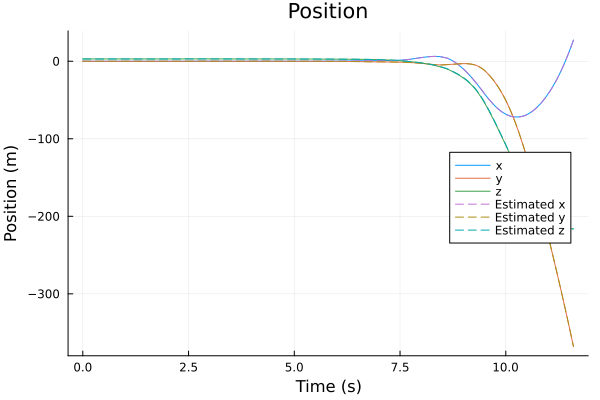

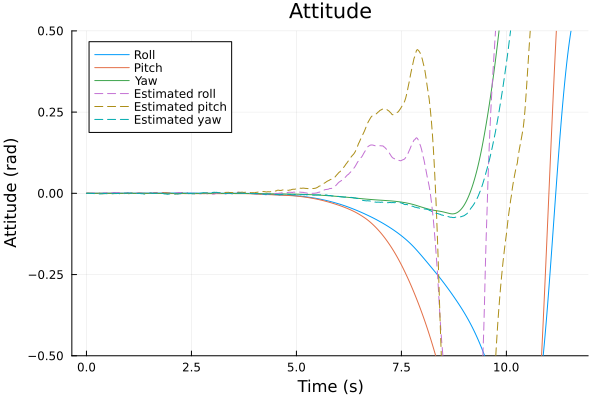

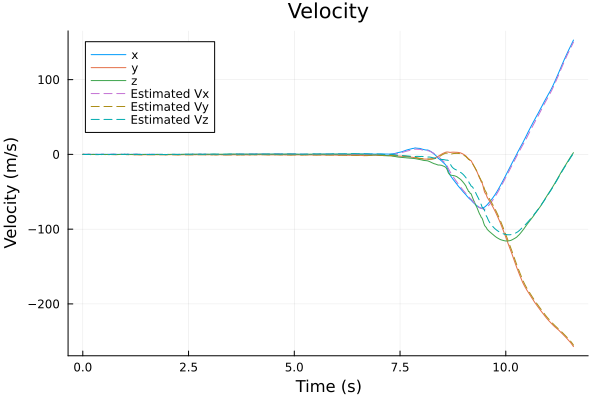

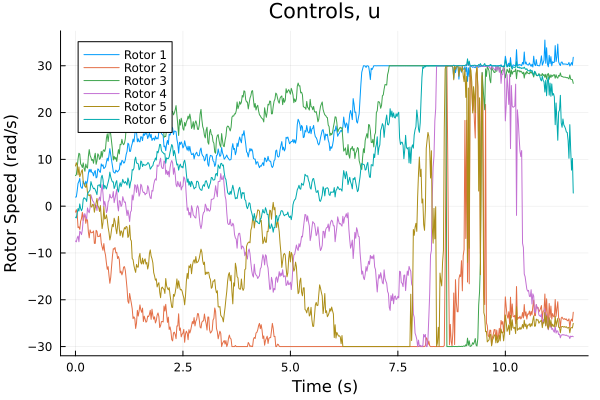

┌ Info: Listening on: 127.0.0.1:8707, thread id: 1
└ @ HTTP.Servers C:\Users\scott\.julia\packages\HTTP\bDoga\src\Servers.jl:367


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8707
└ @ MeshCat C:\Users\scott\.julia\packages\MeshCat\I6NTX\src\visualizer.jl:63


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("drone" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8707))

In [28]:
    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    x̂m= mat_from_vec(x̂)
   # Σm= mat_from_vec(Σ)
  
    plot1= plot(t_vec_sim,Xm[1:3,:]',title = "Position",
    xlabel = "Time (s)", ylabel = "Position (m)",
    label = ["x" "y" "z"])

    plot!(plot1,t_vec_sim, x̂m[1:3,:]', label=["Estimated x" "Estimated y" "Estimated z"], linestyle=:dash, legend=:right)
    display(plot1)

#     display(plot(t_vec_sim,Xm[1:3,:]',title = "Position",
#             xlabel = "Time (s)", ylabel = "Position (m)",
#             label = ["x" "y" "z"]))
     
    plot2= plot(t_vec_sim,Xm[7:9,:]', title = "Attitude",
    xlabel = "Time (s)", ylabel = "Attitude (rad)", ylimits=(-0.5,0.5),
    label = ["Roll" "Pitch" "Yaw"])

    plot!(plot2,t_vec_sim, x̂m[7:9,:]',label=["Estimated roll" "Estimated pitch" "Estimated yaw"], linestyle=:dash)
    display(plot2)

    plot3= plot(t_vec_sim,Xm[4:6,:]', title = "Velocity",
    xlabel = "Time (s)", ylabel = "Velocity (m/s)",
    label = ["x" "y" "z"])

    plot!(plot3,t_vec_sim, x̂m[4:6,:]',label=["Estimated Vx" "Estimated Vy" "Estimated Vz"], linestyle=:dash)
    display(plot3)

    # display(plot(t_vec_sim,Xm[7:9,:]', title = "Attitude",
    #         xlabel = "Time (s)", ylabel = "Attitude (rad)", ylimits=(-0.5,0.5),
    #         label = ["Roll" "Pitch" "Yaw"])) 
    display(plot(t_vec_sim[1:end-1],Um',title = "Controls, u",
            xlabel = "Time (s)", ylabel= "Rotor Speed (rad/s)", label= ["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))  


# mesh cat display
display(animate_hexrotor(X_sim, dt))

In [16]:
# comparing the kalman filter estimates to ground truth
x̂m= mat_from_vec(x̂)
# state_gt_vv= [X̄ for i= 1: N_sim]
# state_gt= mat_from_vec(state_gt_vv)
state_gt= X̄

println(size(x̂m))
println(size(state_gt))


function relative_error(value1, value2)
    if value1 == 0 && value2 == 0
        return 0.0
    end
    abs_error = abs(value1 - value2)
    ref_value = max(abs(value1), abs(value2))
    return abs_error / ref_value
end

#rel_err = relative_error(value1, value2)
#println("Relative Error: ", rel_err)
# MSE between predicted state and ground truth
# MSE_state= 0
# for i= 1:N_sim
#     MSE_state+=
# end

error_x= zeros(N_sim)
for i= 1: length(error_x)
    error_x[i]= relative_error(X̄[1], x̂[i][1])
end

println(error_x)
println(x̂[2])

#plot_kf_state= plot(t_vec_sim, )
 


(12, 581)
(12,)
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [17]:

using StatsBase

mse_value= zeros(length(N_sim))
for i= 1:N_sim
    mse_value[i]= msd(x̂[], X̄)
end

plot(Z)
println(mse_value)
    

ArgumentError: ArgumentError: Package StatsBase not found in current path:
- Run `import Pkg; Pkg.add("StatsBase")` to install the StatsBase package.


In [18]:

using LaTeXStrings

# Define data
x = 1:0.1:10
y = sin.(x)

# Convert data to TikZ coordinates
tikz_data = join(["($x, $y)" for (x, y) in zip(x, y)], ", ")

# Define TikZ code
tikz_code = raw"""
\begin{tikzpicture}
    \begin{axis}[
        xlabel={$x$},
        ylabel={$y$},
        title={Plot of $\sin(x)$},
    ]
    \addplot[color=blue, mark=none] coordinates {
        $tikz_data
    };
    \end{axis}
\end{tikzpicture}
"""
# Define the LaTeX environment with TikZ code
latex_code = raw"""
\documentclass{standalone}
\usepackage{tikz}
\begin{document}
\begin{tikzpicture}
    \begin{axis}[
        xlabel={$x$},
        ylabel={$y$},
        title={Plot of $\sin(x)$},
    ]
    \addplot[color=blue, mark=none] coordinates {
        $tikz_data
    };
    \end{axis}
\end{tikzpicture}
\end{document}
"""

# Save LaTeX code to a .tex file
open("figure.tex", "w") do f
    write(f, latex_code)
end


ArgumentError: ArgumentError: Package LaTeXStrings not found in current path:
- Run `import Pkg; Pkg.add("LaTeXStrings")` to install the LaTeXStrings package.
